## Import data

In [1]:
from scipy.io import arff
import pandas as pd
import tensorflow as tf
import pdb
from sklearn import preprocessing
import numpy as np
from numpy import reshape
from pandas import DataFrame
import os

directory = r'C:\Users\Ideapad320S\Documents\University\Groningen\Year 2\Major project\Model\training_set_addedbyImogen'
train_data = []
for file in os.listdir(directory):
    df_single = pd.read_csv(os.path.join(directory, file))
    del df_single["Unnamed: 0"]
    df_single.astype(int)
    x = df_single.values
    x_scaled = x/100
    df_single = pd.DataFrame(x_scaled)
    train_data.append(df_single) 

Train = []
for i in range(2560):
    day = train_data[i].to_numpy()
    Train.append(day)
Y_train = Train
Y_train = np.reshape(Train, (2560,24,8))
Y_train = np.array(Y_train)
X_train = Y_train

In [2]:
directory = r'C:\Users\Ideapad320S\Documents\University\Groningen\Year 2\Major project\Model\test_set_addedbyImo'
test_data = []
for file in os.listdir(directory):
    df_single = pd.read_csv(os.path.join(directory, file))
    del df_single["Unnamed: 0"]
    df_single.astype(int)
    x = df_single.values
    x_scaled = x/100
    df_single = pd.DataFrame(x_scaled)
    test_data.append(df_single) 

Test = []
for i in range(519):
    day = test_data[i].to_numpy()
    Test.append(day)
Y_test = Test
Y_test = np.reshape(Test, (519,24,8))
Y_test = np.array(Y_test)

## Loss function and VAE model

In [4]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

def KL_bce(y_true, y_pred): #from https://github.com/tensorflow/tensorflow/blob/e5bf8de410005de06a7ff5393fafdf832ef1d4ad/tensorflow/python/keras/losses.py#L1003
  y_pred = ops.convert_to_tensor(y_pred)
  y_true = math_ops.cast(y_true, y_pred.dtype)
  y_true = K.clip(y_true, K.epsilon(), 1)
  y_pred = K.clip(y_pred, K.epsilon(), 1)
  KLweight = 1
  return KLweight*math_ops.reduce_sum(y_true * math_ops.log(y_true / y_pred), axis=-1) + K.mean(K.binary_crossentropy(y_true, y_pred, from_logits=False), axis=-1)


In [5]:
#https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/ style model:
from tensorflow.keras.layers import Input, Dense, Lambda, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def create_model():
    tf.keras.backend.clear_session()
    
    n_z = 4 #latent space dimensions

    # Encoder
    inputs = Input(shape= (24,8))
    LS = LSTM(350, activation='relu', return_sequences=False)(inputs)
    LS_drop = Dropout(0.1)(LS)
    mu = Dense(n_z, activation='linear')(LS_drop)
    log_sigma = Dense(n_z, activation='linear')(LS_drop)

    def sample_z(args):
        mu, log_sigma = args
        eps = K.random_normal(shape=(1,n_z), mean=0., stddev=1.)
        return mu + K.exp(log_sigma / 2) * eps
    # Sample z
    z = Lambda(sample_z)([mu, log_sigma]) 
    # Encoder model
    encoder = Model(inputs, z)

    # Decoder
    # Make decoder layers
    d_input = Input(shape=(n_z))
    d_mu = Dense(n_z, activation='linear')
    decoder_rep = RepeatVector(24)
    d_LS = LSTM(350, activation='relu', return_sequences=True)
    decoder_out = Dense(8, activation='sigmoid')
    # Add decoder layers together
    d_input2 = d_input
    d_mu2 = d_mu(d_input2)
    decoder_rep2 = decoder_rep(d_mu2)
    d_LS2 = d_LS(decoder_rep2)
    outputs = decoder_out(d_LS2)
    # Decoder model
    decoder = Model(d_input2, outputs)

    # Complete VAE model
    # Run inputs through encoder then encoder through decoder to outputs
    latent = encoder(inputs)
    outputs = decoder(latent)
    vae = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(lr=1e-4)
    vae.compile(
        optimizer=optimizer, 
        loss=KL_bce,  
        metrics = ['mse']) 
    return vae, encoder, decoder
#vae, encoder, decoder = create_model()
#history = vae.fit(
#    X_train, 
#    Y_train, 
#    batch_size=2560,
#    epochs=600) 

In [4]:
vae, encoder, decoder = create_model()
vae.summary()
encoder.summary()
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 8)]           0         
_________________________________________________________________
model (Model)                (None, 4)                 505408    
_________________________________________________________________
model_1 (Model)              (None, 24, 8)             499828    
Total params: 1,005,236
Trainable params: 1,005,236
Non-trainable params: 0
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 8)]      0                                            
___________________________________________________________________

## Baseline investigations

In [4]:
Total_input = np.concatenate((X_train, Y_test))
naive = np.zeros([3079,24,8])
naive[:,:,0] = 1
diff = (Total_input - naive)
print(np.mean(np.square(diff)))
print(np.std(diff))

#for X_train only:
#0.0666318056233724
#0.25812600125323665

#for train and test combined:
#0.0660839289339071
#0.2570623443977928

0.0660839289339071
0.2570623443977928


25621
34.67170076864783


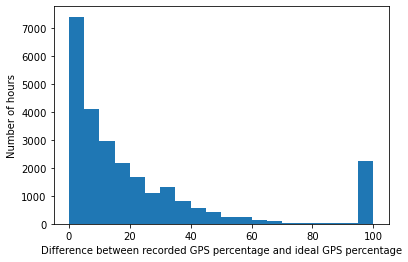

In [12]:
import numpy as np
import matplotlib.pyplot as plt

GPS = Total_input[:,:,0] + Total_input[:,:,1] + Total_input[:,:,2]

Lost = 0
Lost_diff = []
for i in range(3079):
  for j in range(24):
    if GPS[i,j] < 1:
      Lost = Lost + 1
      Lost_diff.append(1-GPS[i,j])
print(Lost)
Perc_lost = 100*Lost/(3079*24)
print(Perc_lost) #for total input: 34.67170076864783 #for X_train: 35.100911458333336
Lost_diff = np.multiply(Lost_diff,100)
plt.hist(Lost_diff, 20)
plt.xlabel('Difference between recorded GPS percentage and ideal GPS percentage')
plt.ylabel('Number of hours')
plt.savefig('lost_GPS.png')

## Optimise LSTM units

In [11]:
from tensorflow.keras.layers import Input, Dense, Lambda, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def create_model2():
    tf.keras.backend.clear_session()

    n_z = 4 #latent space dimensions

    # Encoder
    inputs = Input(shape= (24,8))
    LS = LSTM(units, activation='relu', return_sequences=False)(inputs)
    LS_drop = Dropout(0.1)(LS) 
    mu = Dense(n_z, activation='linear')(LS_drop)
    log_sigma = Dense(n_z, activation='linear')(LS_drop)

    def sample_z(args):
        mu, log_sigma = args
        eps = K.random_normal(shape=(1,n_z), mean=0., stddev=1.)
        return mu + K.exp(log_sigma / 2) * eps
    # Sample z
    z = Lambda(sample_z)([mu, log_sigma]) 

    encoder2 = Model(inputs, z)

    # Decoder
    # Make decoder layers
    d_input = Input(shape=(n_z))
    d_mu = Dense(n_z, activation='linear') 
    decoder_rep = RepeatVector(24) 
    d_LS = LSTM(units, activation='relu', return_sequences=True)
    decoder_out = Dense(8, activation='sigmoid')
    # Add decoder layers together
    d_input2 = d_input
    d_mu2 = d_mu(d_input2)
    decoder_rep2 = decoder_rep(d_mu2)
    d_LS2 = d_LS(decoder_rep2)
    outputs = decoder_out(d_LS2)
    # Decoder model
    decoder2 = Model(d_input2, outputs)

    # Complete VAE model
    # Run inputs through encoder then encoder through decoder to outputs
    latent = encoder2(inputs)
    outputs = decoder2(latent) 
    vae2 = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(lr=1e-4)
    vae2.compile(
        optimizer=optimizer, 
        loss=KL_bce,  
        metrics = ['mse']) 
    return vae2, encoder2, decoder2


In [12]:
def train_and_evaluate_model(model, data_reshape, data, Data_reshape, Data):
    tf.keras.backend.clear_session()
    model.fit(data_reshape, data, batch_size=2560, epochs=600) #training subset
    score = model.evaluate(Data_reshape, Data, verbose=0) #testing subset
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    return score

from sklearn.model_selection import KFold
Y = [250,300,350,400] #All the numbers to be tested
MSE2 = []
Loss2 = []

for y in Y:
    MSE_same_k2 = []
    Loss_same_k2 = []
    units = y
    data_reshape, data = X_train, Y_train 
    kf = KFold(n_splits=5) 
    i=0
    for train, test in kf.split(X_train):
        print("%s %s" % (train, test))
        i=i+1
        print("Running Fold", i,"/", 5,";", "y value:", y)
        vae2 = None
        tf.keras.backend.clear_session()
        vae2, encoder2, decoder2 = create_model2()
        score = train_and_evaluate_model(vae2, data_reshape[train], data[train], data_reshape[test], data[test])
        MSE_same_k2.append(score[1]) 
        Loss_same_k2.append(score[0])
    
    MSE2.append(MSE_same_k2)
    Loss2.append(Loss_same_k2)

[ 512  513  514 ... 2557 2558 2559] [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 23

KeyboardInterrupt: 

Text(0, 0.5, 'Mean squared error')

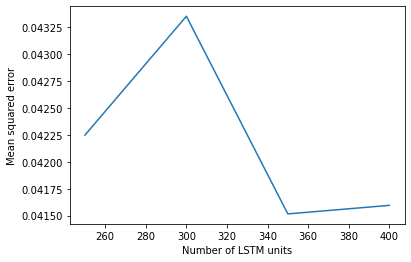

In [19]:
#MSE for KL weight = BCE weight
import statistics
Y = [250,300,350,400]
means = []
means.append(statistics.mean([0.04112079367041588, 0.042139094322919846, 0.04068152606487274, 0.04163040593266487, 0.045667510479688644]))
means.append(statistics.mean([0.039269279688596725, 0.04598331078886986, 0.041193533688783646, 0.04114711657166481, 0.04916979745030403]))
means.append(statistics.mean([0.041175760328769684, 0.036767542362213135, 0.03940737619996071, 0.04109915345907211, 0.04913022741675377]))
means.append(statistics.mean([0.04122420772910118, 0.04208075627684593, 0.03923307731747627, 0.04173581302165985, 0.04370298609137535]))

plt.plot(Y,means)
plt.xlabel('Number of LSTM units')
plt.ylabel('Mean squared error')

Text(0, 0.5, 'Loss')

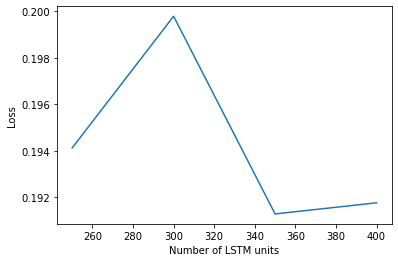

In [21]:
#Loss for KL weight = BCE weight
import statistics

Y = [250,300,350,400]
means = []
means.append(statistics.mean([0.191999152302742, 0.18628689646720886, 0.18710742890834808, 0.18990087509155273, 0.2153317630290985]))
means.append(statistics.mean([0.1856982260942459, 0.212956503033638, 0.18813790380954742, 0.18904796242713928, 0.2230806201696396]))
means.append(statistics.mean([0.1915203034877777, 0.17193540930747986, 0.18281027674674988, 0.1873866766691208, 0.22280237078666687]))
means.append(statistics.mean([0.19193696975708008, 0.1857466995716095, 0.18141627311706543, 0.19102734327316284, 0.20871423184871674]))

plt.plot(Y,means)
plt.xlabel('Number of LSTM units')
plt.ylabel('Loss')

## Evaluate model performance

In [6]:
#with adam lr=1e-4, KL weight = 1, LSTM units = 350
vae, encoder, decoder = create_model()
history = vae.fit(
    X_train, 
    Y_train, 
    batch_size=2560,
    epochs=600)
#vae.save('final_vae.h5')
#encoder.save('final_encoder.h5')
#decoder.save('final_decoder.h5')

Train on 2560 samples
Epoch 1/600
2560/2560 [==============================] - 9s 4ms/sample - loss: 1.1736 - mse: 0.2371
Epoch 2/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1161 - mse: 0.2287
Epoch 3/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1429 - mse: 0.2289
Epoch 4/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1303 - mse: 0.2309
Epoch 5/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1286 - mse: 0.2285
Epoch 6/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.0927 - mse: 0.2325
Epoch 7/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1328 - mse: 0.2290
Epoch 8/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1098 - mse: 0.2277
Epoch 9/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1297 - mse: 0.2318
Epoch 10/600
2560/2560 [==============================] - 6s 2ms/sample - loss

In [8]:
vae.load_weights('final_vae_weights.h5')
score = vae.evaluate(X_train, X_train, verbose=0)
print('Training loss:', score[0])
print('Training accuracy:', score[1])
#Model used for analysis:
#Training loss: 0.1679834215901792
#Training accuracy: 0.039721385

Training loss: 0.1679834215901792
Training accuracy: 0.039721385


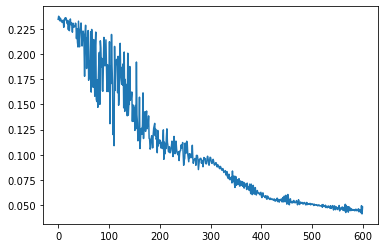

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history["mse"])
plt.savefig('final_vae_mse-in-training.png')
  
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'final_vae_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
    

In [19]:
#Have to save model weights:
#vae.save_weights('final_vae_weights.h5') #https://blog.paperspace.com/working-with-the-lambda-layer-in-keras/
#encoder.save_weights('final_encoder_weights.h5')
#decoder.save_weights('final_decoder_weights.h5')

In [14]:
#vae.load_weights('final_vae_weights.h5')
score = vae.evaluate(Y_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
#Model used for analysis:
#Test loss: 0.17869165539741516
#Test accuracy: 0.040553197

#For averages (trained and evaluated model 10 times):
#Test loss: [0.17869165539741516, 0.15290487863424884, 0.1844840400595656, 0.18996801289060442, 0.17242139945370155, 0.19919099571158203, 0.20350809306308254, 0.19399218022938178, 0.20292475176454738, 0.18962881836128603]
#Test accuracy: [0.040553197, 0.03946539, 0.046944954, 0.046291176, 0.045124214, 0.048476256, 0.048875097, 0.04646904, 0.052407384, 0.04564637]

Test loss: 0.17869165539741516
Test accuracy: 0.040553197


In [11]:
loss_list = [0.17869165539741516, 0.15290487863424884, 0.1844840400595656, 0.18996801289060442, 0.17242139945370155, 0.19919099571158203, 0.20350809306308254, 0.19399218022938178, 0.20292475176454738, 0.18962881836128603]
accuracy_list = [0.040553197, 0.03946539, 0.046944954, 0.046291176, 0.045124214, 0.048476256, 0.048875097, 0.04646904, 0.052407384, 0.04564637]
print('Average loss:', np.mean(loss_list))
print('loss std dev:', np.std(loss_list))
print('Average MSE:', np.mean(accuracy_list))
print('MSE std dev:', np.std(accuracy_list))

Average loss: 0.18677148255654152
loss std dev: 0.014795928290271631
Average MSE: 0.0460253078
MSE std dev: 0.003604230258006411


## Interpret latent constructs

(3079, 4)


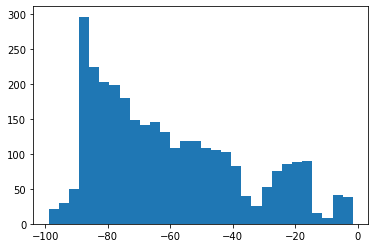

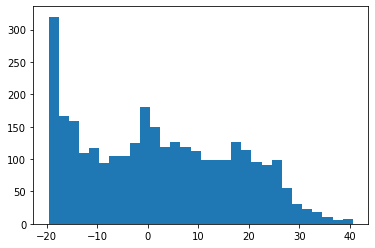

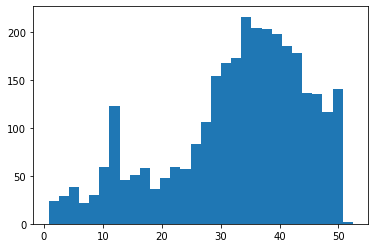

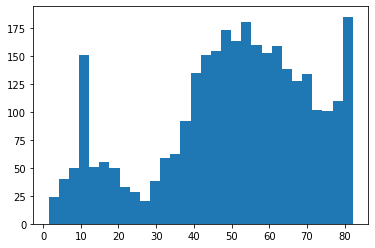

In [5]:
vae, encoder, decoder = create_model()
encoder.load_weights('final_encoder_weights.h5')
decoder.load_weights('final_decoder_weights.h5')
latentSpace_train = encoder.predict(X_train)
latentSpace_test = encoder.predict(Y_test)
setting_range_interpret = np.concatenate((latentSpace_train, latentSpace_test)) 
print(setting_range_interpret.shape)
setting_range_interpret = np.transpose(setting_range_interpret)
vary = []
for i in range(4):
    plt.hist(setting_range_interpret[i],30)
    plt.show()
    vary.append(min(setting_range_interpret[i]))
    vary.append(max(setting_range_interpret[i]))

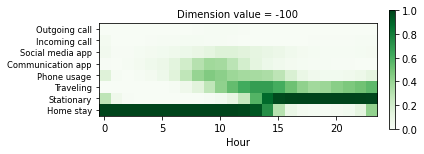

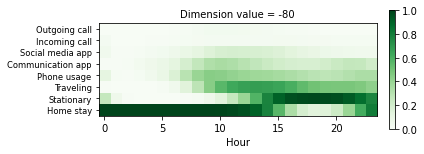

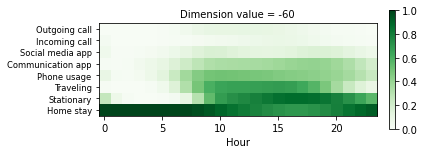

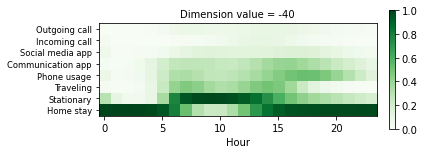

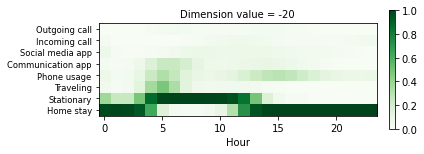

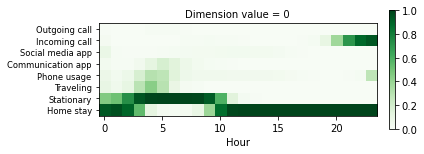

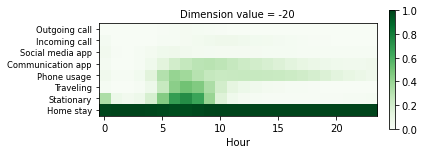

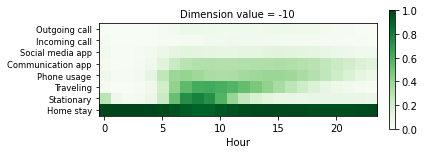

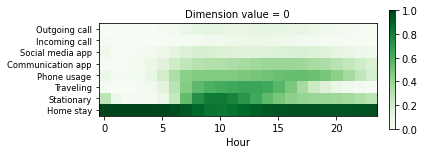

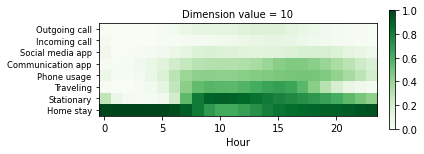

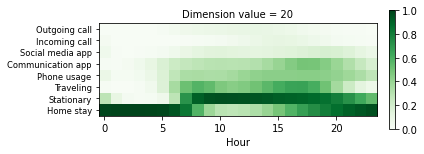

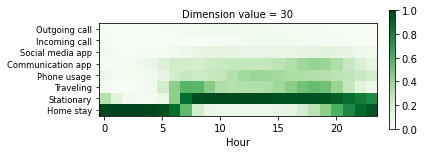

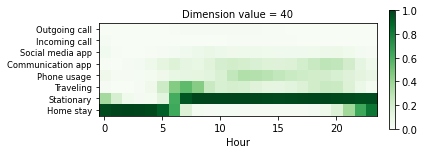

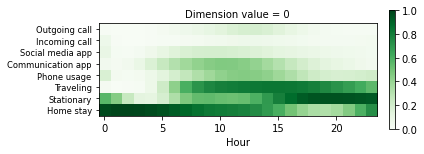

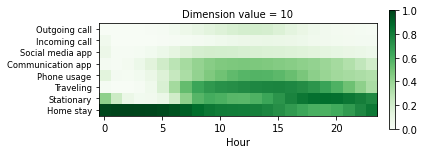

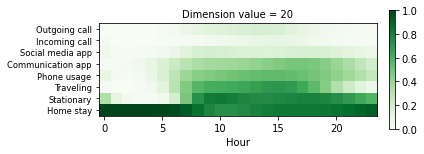

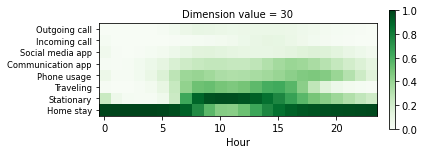

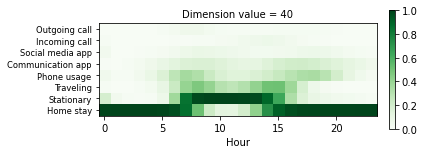

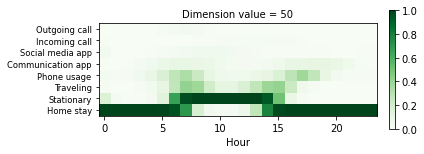

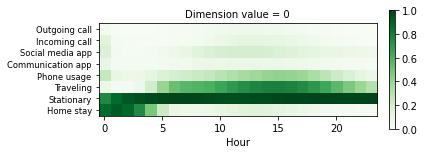

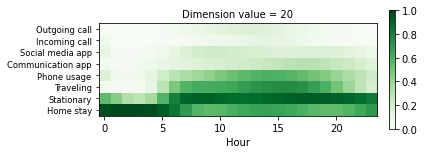

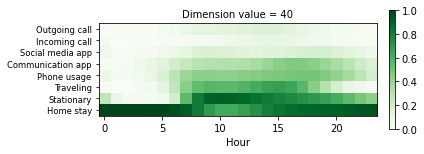

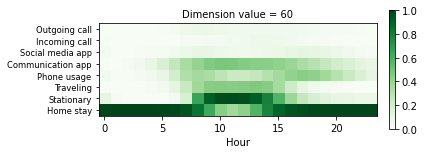

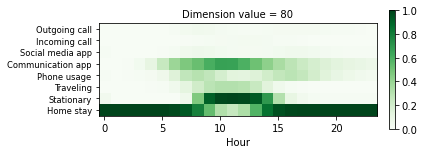

In [13]:
channel_names = ['Home stay','Stationary','Traveling','Phone usage','Communication app','Social media app','Incoming call','Outgoing call']

position =[0,1,2,3] #which latent space dimension
results = []

vary = [[-100, -80, -60, -40, -20, 0],[-20, -10, 0, 10, 20, 30, 40],[0, 10, 20, 30, 40, 50],[0, 20, 40, 60, 80]] #rounded, tailored to each dimension

i = 0
for p in position:
    Z=[-50,10,25,40] #midpoints
    V = vary[p]    
    for v in V:
        Z[p]=float(v)
        pseudoOutputs = decoder.predict([Z])
        results.append(pseudoOutputs) #store output from decoder
        pattern = np.transpose(np.reshape(results[i], (24,8)))
        plt.imshow(pattern, cmap='Greens', interpolation='nearest')
        plt.colorbar(fraction=0.02, pad=0.04)
        plt.gca().invert_yaxis()
        plt.yticks(range(len(channel_names)), channel_names, size='small')
        plt.xticks(fontsize = 10)
        plt.xlabel('Hour')
        plt.clim(0.0,1.0)
        plt.tight_layout()
        plt.title("Dimension value = "+ str(v), fontsize = 10)
        plt.savefig('interpret' + 'position' + str(p) + 'vary' + str(v) + '.png')
        plt.show()
        i = i + 1
        

## Save latent space representations for comparison with SFS and CNN-VAE

In [31]:
import pandas as pd
vae, encoder, decoder = create_model()
encoder.load_weights('final_encoder_weights.h5')
latentSpace_train = encoder.predict(X_train)
latentSpace_test = encoder.predict(Y_test)
df_train = pd.DataFrame(latentSpace_train)
df_test = pd.DataFrame(latentSpace_test)

df_train.to_csv('LSTMConstructs_train-set.csv', index=False) 
df_test.to_csv('LSTMConstructs_test-set.csv', index=False) 

## Coordinate rotation

In [ ]:
#Save latent space representations from different model versions
vae, encoder, decoder = create_model()
vae.fit(X_train,Y_train, batch_size=2560, epochs=600)
results1 = vae.predict(X_train, verbose = 0)
latent1 = encoder.predict(X_train)
df1 = pd.DataFrame(latent1)
df1.to_csv("latent3_2207.csv")
vae = None
encoder = None

vae, encoder, decoder = create_model()
vae.fit(X_train,Y_train, batch_size=2560, epochs=600)
results2 = vae.predict(X_train, verbose = 0)
latent2 = encoder.predict(X_train)
df2 = pd.DataFrame(latent2)
df2.to_csv("latent4_2207.csv")
vae = None
encoder = None

Train on 2560 samples
Epoch 1/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1735 - mse: 0.2365
Epoch 2/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1755 - mse: 0.2366
Epoch 3/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1006 - mse: 0.2352
Epoch 4/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1499 - mse: 0.2355
Epoch 5/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1110 - mse: 0.2338
Epoch 6/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.0855 - mse: 0.2316
Epoch 7/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1349 - mse: 0.2332
Epoch 8/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1416 - mse: 0.2346
Epoch 9/600
2560/2560 [==============================] - 6s 2ms/sample - loss: 1.1586 - mse: 0.2334
Epoch 10/600
2560/2560 [==============================] - 6s 2ms/sample - loss

## Look at VAE output

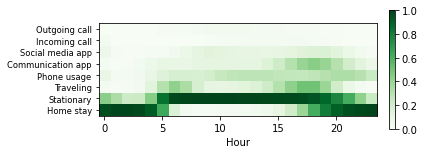

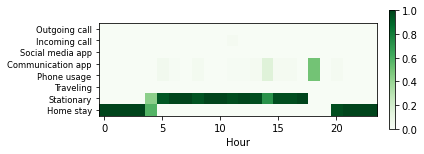

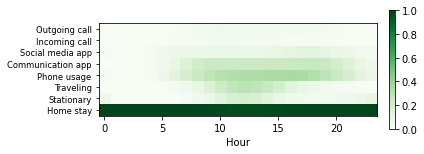

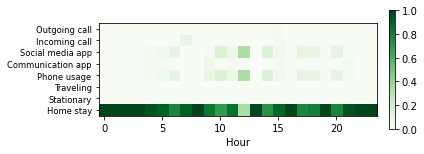

In [7]:
vae, encoder, decoder = create_model()
vae.load_weights('final_vae_weights.h5')
Output = vae.predict(X_train, verbose = 0)
channel_names = ['Home stay','Stationary','Traveling','Phone usage','Communication app','Social media app','Incoming call','Outgoing call']

#Use these to show difference between the VAE output and the original activity pattern:

plt.imshow(np.transpose(np.reshape(Output[1000], (24,8))), cmap='Greens', interpolation='nearest')
plt.colorbar(fraction=0.02, pad=0.04)
plt.gca().invert_yaxis()
plt.yticks(range(len(channel_names)), channel_names, size='small')
plt.xlabel('Hour')
plt.clim(0.0,1.0)
plt.tight_layout()
plt.savefig('Xtrain1000_reconstruction.png')
plt.show()

plt.imshow(np.transpose(np.reshape(X_train[1000], (24,8))), cmap='Greens', interpolation='nearest')
plt.colorbar(fraction=0.02, pad=0.04)
plt.gca().invert_yaxis()
plt.yticks(range(len(channel_names)), channel_names, size='small')
plt.xlabel('Hour')
plt.clim(0.0,1.0)
plt.tight_layout()
plt.savefig('Xtrain1000_original.png')
plt.show()

plt.imshow(np.transpose(np.reshape(Output[2000], (24,8))), cmap='Greens', interpolation='nearest')
plt.colorbar(fraction=0.02, pad=0.04)
plt.gca().invert_yaxis()
plt.yticks(range(len(channel_names)), channel_names, size='small')
plt.xlabel('Hour')
plt.clim(0.0,1.0)
plt.tight_layout()
plt.savefig('Xtrain2000_reconstruction.png')
plt.show()

plt.imshow(np.transpose(np.reshape(X_train[2000], (24,8))), cmap='Greens', interpolation='nearest')
plt.colorbar(fraction=0.02, pad=0.04)
plt.gca().invert_yaxis()
plt.yticks(range(len(channel_names)), channel_names, size='small')
plt.xlabel('Hour')
plt.clim(0.0,1.0)
plt.tight_layout()
plt.savefig('Xtrain2000_original.png')
plt.show()

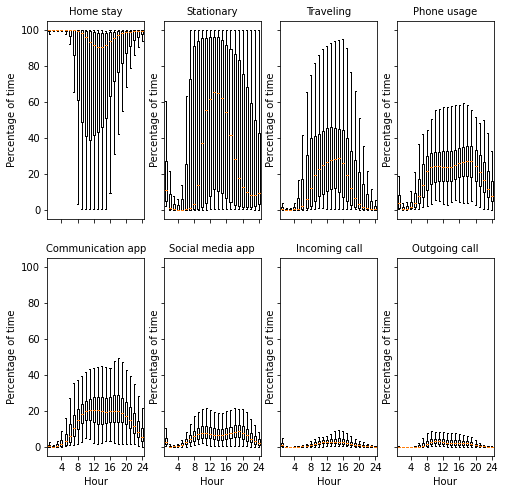

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fs = 10  # fontsize
plt.rc('xtick', labelsize=fs) 
plt.rc('ytick', labelsize=fs) 

fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(8, 8))

majors = range(0, 26, 4)

vae, encoder, decoder = create_model()
vae.load_weights('final_vae_weights.h5')
Output = vae.predict(X_train, verbose = 0)
Output_test = vae.predict(Y_test, verbose = 0)
Total_Output = np.concatenate((Output, Output_test))*100

channel_names = ['Home stay','Stationary','Traveling','Phone usage','Communication app','Social media app','Incoming call','Outgoing call']

for c in range(8):
    Arrays = []
    for i in range(24):
        Arrays.append(Total_Output[:,i,c])
    if c < 4:
        axes[0, c].boxplot(Arrays, showfliers=False)
        axes[0, c].set_title(channel_names[c], fontsize=fs)
        axes[0, c].xaxis.set_major_locator(ticker.FixedLocator(majors))
        axes[0, c].set(ylabel='Percentage of time')
    else:
        axes[1, c-4].boxplot(Arrays, showfliers=False)
        axes[1, c-4].set_title(channel_names[c], fontsize=fs)
        axes[1, c-4].xaxis.set_major_locator(ticker.FixedLocator(majors))
        axes[1, c-4].xaxis.set_major_formatter(ticker.FixedFormatter(majors))
        axes[1, c-4].set(xlabel='Hour')
        axes[1, c-4].set(ylabel='Percentage of time')
        
plt.savefig('boxplot_reco.png')

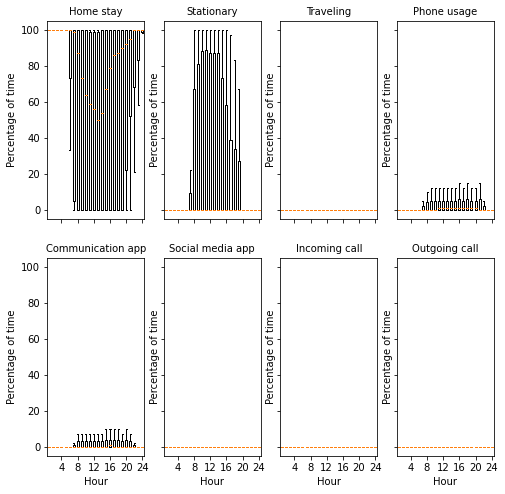

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fs = 10  # fontsize
plt.rc('xtick', labelsize=fs) 
plt.rc('ytick', labelsize=fs) 

fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(8, 8))

majors = range(0, 26, 4)

Total_input = np.concatenate((X_train, Y_test))*100 

channel_names = ['Home stay','Stationary','Traveling','Phone usage','Communication app','Social media app','Incoming call','Outgoing call']

for c in range(8):
    OriginalArrays = []
    for i in range(24):
        OriginalArrays.append(Total_input[:,i,c])
    if c < 4:
        axes[0, c].boxplot(OriginalArrays, showfliers = False)
        axes[0, c].set_title(channel_names[c], fontsize=fs)
        axes[0, c].xaxis.set_major_locator(ticker.FixedLocator(majors))
        axes[0, c].set(ylabel='Percentage of time')
    else:
        axes[1, c-4].boxplot(OriginalArrays, showfliers = False)
        axes[1, c-4].set_title(channel_names[c], fontsize=fs)
        axes[1, c-4].xaxis.set_major_locator(ticker.FixedLocator(majors))
        axes[1, c-4].xaxis.set_major_formatter(ticker.FixedFormatter(majors))
        axes[1, c-4].set(xlabel='Hour')
        axes[1, c-4].set(ylabel='Percentage of time')
        
plt.savefig('boxplot_orig.png')
